In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from datetime import datetime, timedelta
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os

In [3]:
# Set style and suppress warnings
plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

print("✅ Advanced analysis environment ready!")


✅ Advanced analysis environment ready!


In [7]:
print("📊 Loading processed data...")

# Load the merged dataset from Notebook 1 (assuming it's in Google Drive)
try:
    # IMPORTANT: Replace '/path/to/your/file/on/drive/processed_data.csv' with the actual path to your file in Google Drive
    merged_df = pd.read_csv('/content/drive/MyDrive/path/to/your/file/processed_data.csv')

    # Check if 'Date' column exists and convert to datetime
    if 'Date' in merged_df.columns:
        merged_df['Date'] = pd.to_datetime(merged_df['Date'])
    else:
        print("❌ Error: 'Date' column not found in the DataFrame.")
        # You might want to add code here to handle the missing column,
        # e.g., exit the script or try to infer the date from another column.
        # For now, we'll stop the execution to avoid further errors.
        raise KeyError("'Date' column not found")


    if 'time' in merged_df.columns:
        merged_df['time'] = pd.to_datetime(merged_df['time'])
    else:
        print("⚠️ Warning: 'time' column not found in the DataFrame. Skipping time conversion.")


    print(f"✅ Processed data loaded: {merged_df.shape}")

    # Verify data structure
    print(f"Date range: {merged_df['Date'].min()} to {merged_df['Date'].max()}")
    print(f"Sentiment distribution: {merged_df['classification'].value_counts().to_dict()}")

    # ==============================================================================
    # ADVANCED CORRELATION ANALYSIS
    # ==============================================================================

    print("\n🔍 ADVANCED CORRELATION ANALYSIS")
    print("-" * 40)

    # Create comprehensive sentiment-based analysis
    def analyze_by_sentiment(df, metric_col, sentiment_col='classification'):
        """Analyze a metric by sentiment with statistical tests"""
        results = {}

        for sentiment in df[sentiment_col].unique():
            subset = df[df[sentiment_col] == sentiment][metric_col]
            results[sentiment] = {
                'mean': subset.mean(),
                'median': subset.median(),
                'std': subset.std(),
                'count': len(subset),
                'q25': subset.quantile(0.25),
                'q75': subset.quantile(0.75)
            }

        return results

    # Analyze key metrics by sentiment
    metrics = ['Closed PnL', 'size', 'position_value']
    sentiment_analysis = {}

    for metric in metrics:
        sentiment_analysis[metric] = analyze_by_sentiment(merged_df, metric)

        # Perform statistical test
        fear_data = merged_df[merged_df['classification'] == 'Fear'][metric]
        greed_data = merged_df[merged_df['classification'] == 'Greed'][metric]

        if len(fear_data) > 0 and len(greed_data) > 0:
            t_stat, p_value = stats.ttest_ind(fear_data, greed_data)
            print(f"\n{metric.upper()} Analysis:")
            print(f"  Fear: μ={fear_data.mean():.4f}, σ={fear_data.std():.4f}")
            print(f"  Greed: μ={greed_data.mean():.4f}, σ={greed_data.std():.4f}")
            print(f"  T-test: t={t_stat:.4f}, p={p_value:.4f} {'✅ Significant' if p_value < 0.05 else '❌ Not significant'}")
        else:
            print(f"\n{metric.upper()} Analysis: Not enough data for statistical test.")


except FileNotFoundError:
    print(f"❌ Error loading processed data: File not found. Please check the path in Google Drive.")
    print("Make sure you have mounted your Google Drive and the path is correct.")
except KeyError as ke:
    print(f"❌ Data processing failed: {ke}")
except Exception as e:
    print(f"❌ An unexpected error occurred: {e}")

📊 Loading processed data...
✅ Processed data loaded: (211218, 26)
Date range: 2023-05-01 00:00:00 to 2025-05-01 00:00:00
Sentiment distribution: {'Fear': 61837, 'Greed': 50303, 'Extreme Greed': 39992, 'Neutral': 37686, 'Extreme Fear': 21400}

🔍 ADVANCED CORRELATION ANALYSIS
----------------------------------------

CLOSED PNL Analysis:
  Fear: μ=54.2904, σ=935.3554
  Greed: μ=42.7436, σ=1116.0284
  T-test: t=1.8847, p=0.0595 ❌ Not significant
❌ Data processing failed: 'size USD'



💰 PROFITABILITY ANALYSIS
----------------------------------------


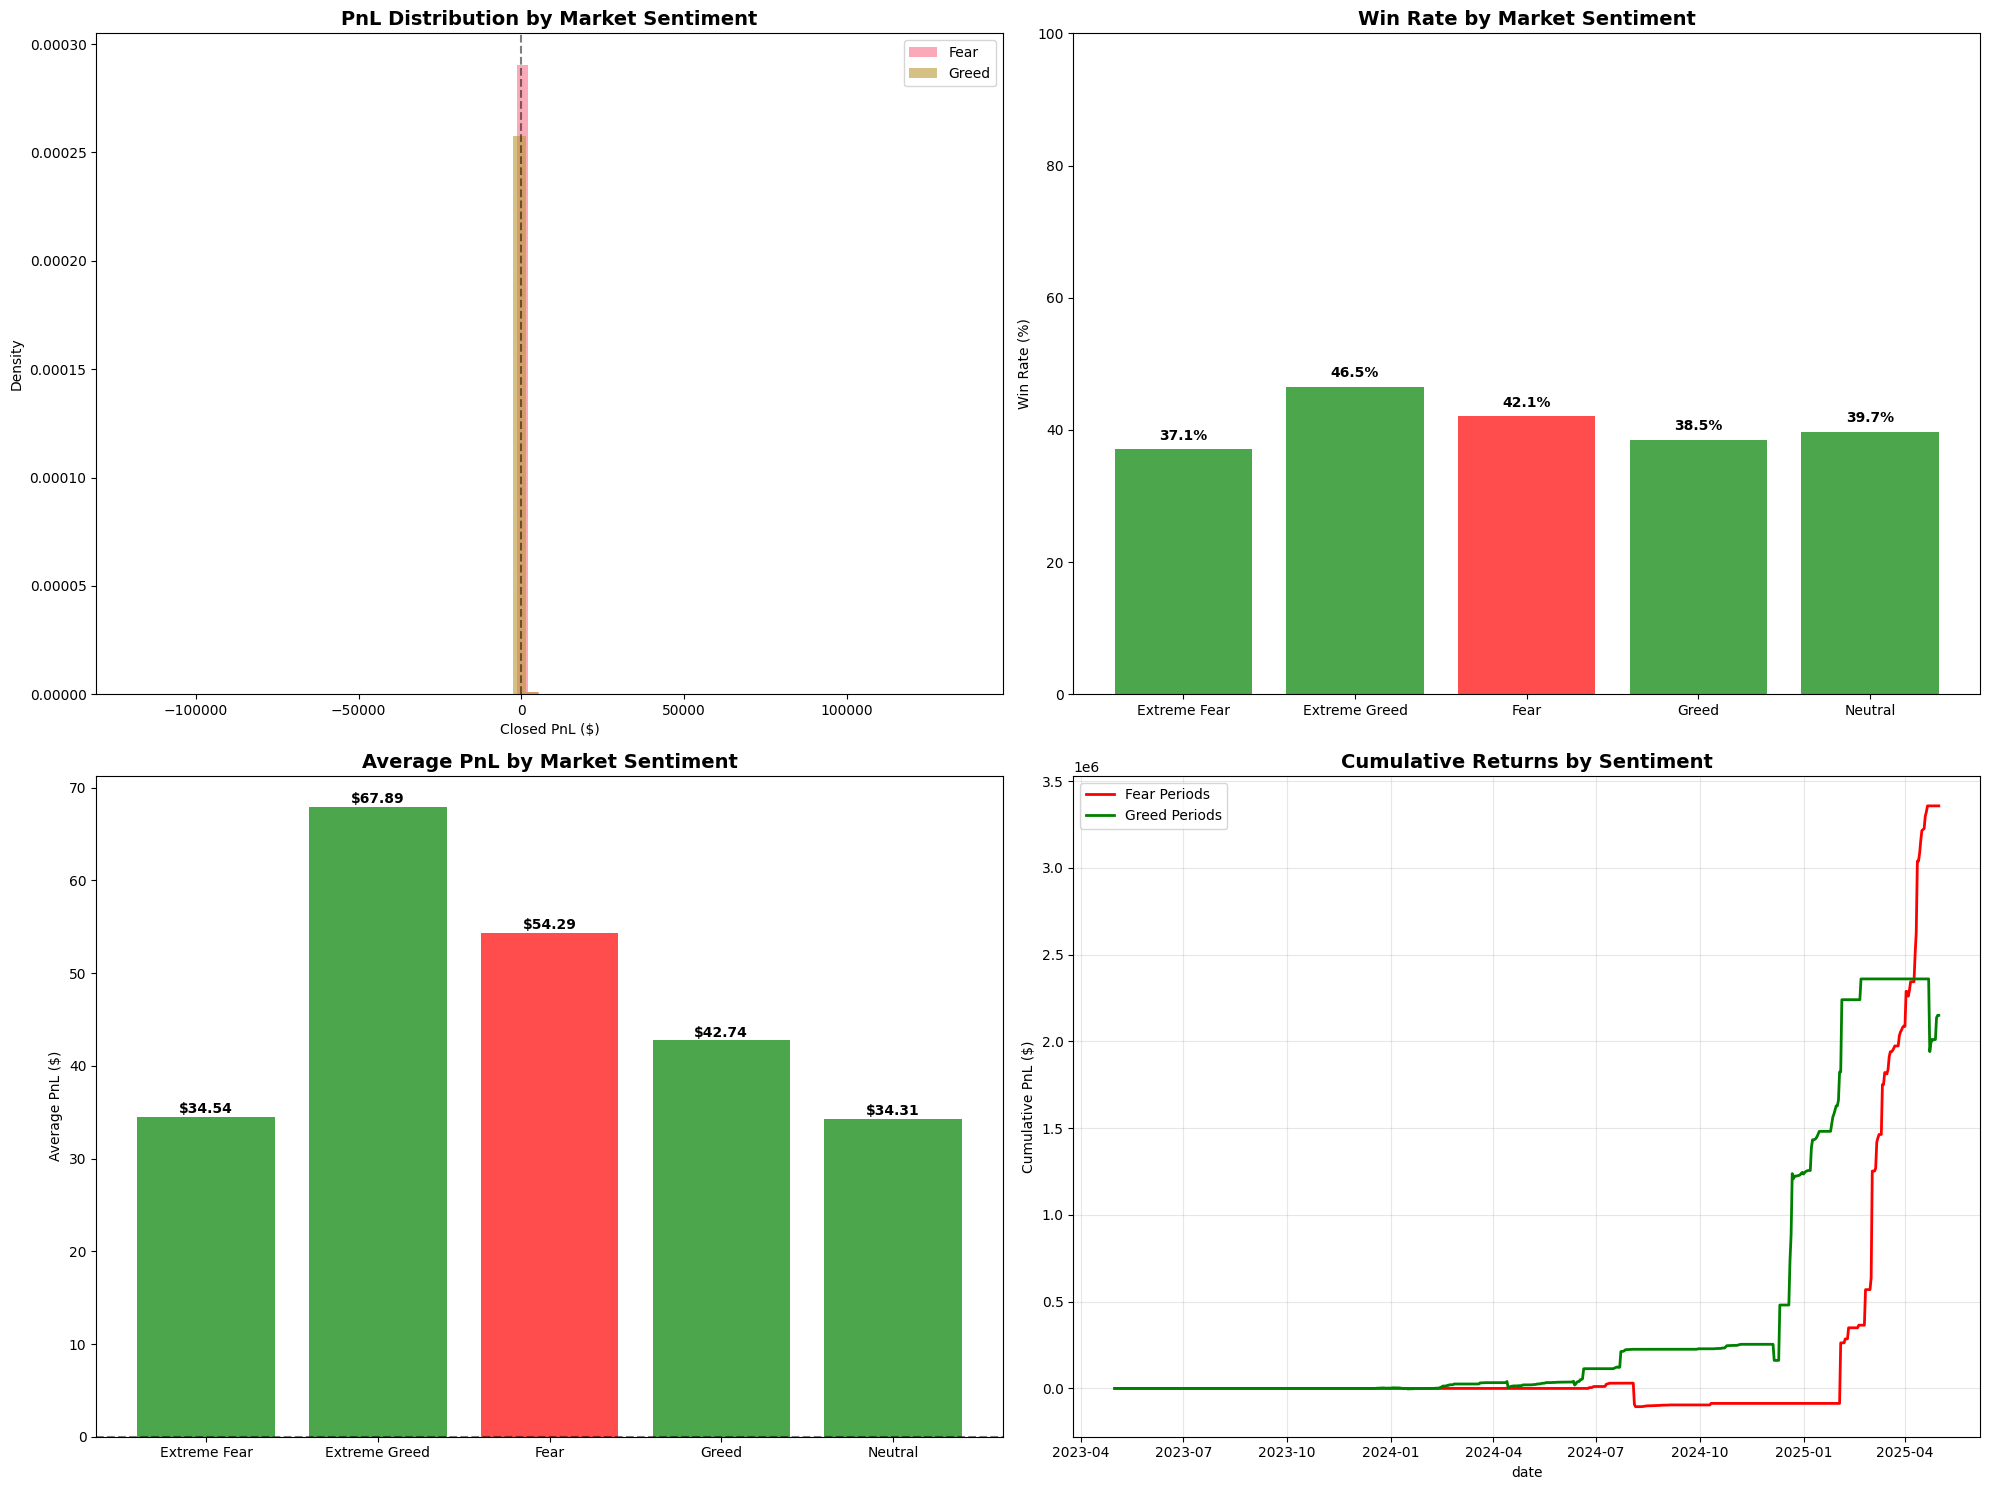

In [12]:
print("\n💰 PROFITABILITY ANALYSIS")
print("-" * 40)

# Create detailed profitability analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# 1. PnL Distribution by Sentiment
for sentiment in ['Fear', 'Greed']:
    data = merged_df[merged_df['classification'] == sentiment]['Closed PnL']
    ax1.hist(data, bins=50, alpha=0.6, label=sentiment, density=True)
ax1.set_title('PnL Distribution by Market Sentiment', fontsize=14, fontweight='bold')
ax1.set_xlabel('Closed PnL ($)')
ax1.set_ylabel('Density')
ax1.legend()
ax1.axvline(0, color='black', linestyle='--', alpha=0.5)

# 2. Win Rate by Sentiment
win_rates = merged_df.groupby('classification').apply(
    lambda x: (x['Closed PnL'] > 0).mean() * 100
).reset_index()
win_rates.columns = ['Sentiment', 'Win_Rate']

colors = ['red' if x == 'Fear' else 'green' for x in win_rates['Sentiment']]
bars = ax2.bar(win_rates['Sentiment'], win_rates['Win_Rate'], color=colors, alpha=0.7)
ax2.set_title('Win Rate by Market Sentiment', fontsize=14, fontweight='bold')
ax2.set_ylabel('Win Rate (%)')
ax2.set_ylim(0, 100)

# Add value labels on bars
for bar, value in zip(bars, win_rates['Win_Rate']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. Average PnL by Sentiment
avg_pnl = merged_df.groupby('classification')['Closed PnL'].mean().reset_index()
colors = ['red' if x == 'Fear' else 'green' for x in avg_pnl['classification']]
bars = ax3.bar(avg_pnl['classification'], avg_pnl['Closed PnL'], color=colors, alpha=0.7)
ax3.set_title('Average PnL by Market Sentiment', fontsize=14, fontweight='bold')
ax3.set_ylabel('Average PnL ($)')
ax3.axhline(0, color='black', linestyle='--', alpha=0.5)

# Add value labels
for bar, value in zip(bars, avg_pnl['Closed PnL']):
    ax3.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + (0.1 if value > 0 else -0.5),
             f'${value:.2f}', ha='center', va='bottom' if value > 0 else 'top',
             fontweight='bold')

# 4. Cumulative Returns by Sentiment
daily_returns = merged_df.groupby(['date', 'classification'])['Closed PnL'].sum().reset_index()
pivot_returns = daily_returns.pivot(index='date', columns='classification', values='Closed PnL').fillna(0)

if 'Fear' in pivot_returns.columns and 'Greed' in pivot_returns.columns:
    pivot_returns['Fear_Cumulative'] = pivot_returns['Fear'].cumsum()
    pivot_returns['Greed_Cumulative'] = pivot_returns['Greed'].cumsum()

    ax4.plot(pivot_returns.index, pivot_returns['Fear_Cumulative'],
             color='red', label='Fear Periods', linewidth=2)
    ax4.plot(pivot_returns.index, pivot_returns['Greed_Cumulative'],
             color='green', label='Greed Periods', linewidth=2)
    ax4.set_title('Cumulative Returns by Sentiment', fontsize=14, fontweight='bold')
    ax4.set_xlabel('date')
    ax4.set_ylabel('Cumulative PnL ($)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/output/pnl_sentiment_correlation.png', dpi=300, bbox_inches='tight')
plt.show()


⚠️ RISK ANALYSIS
----------------------------------------


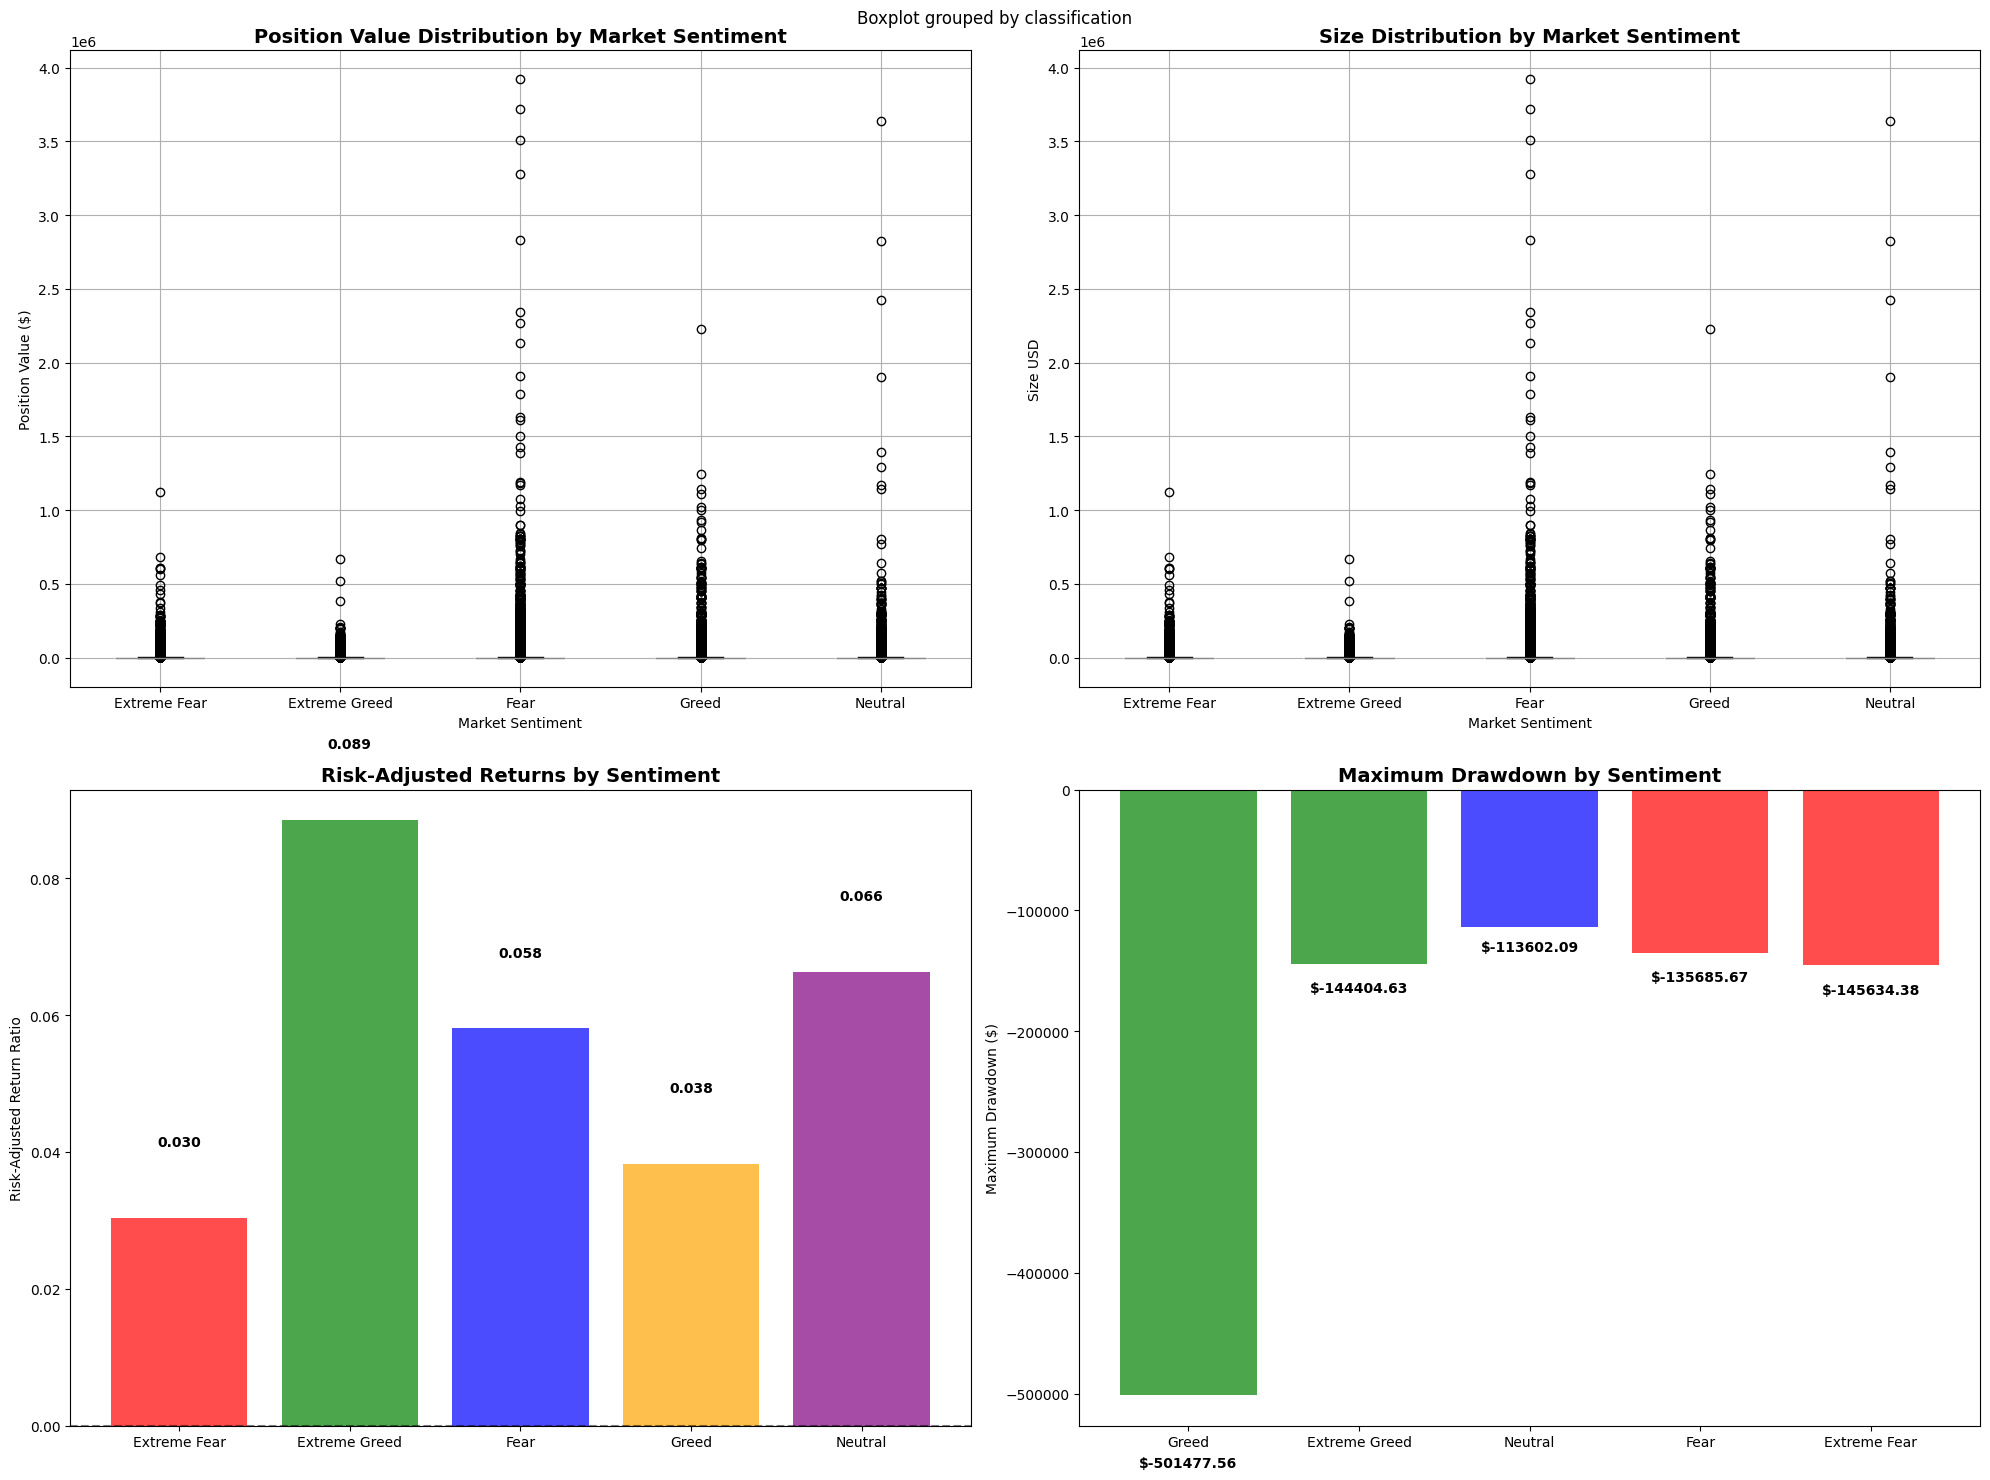


Risk Metrics Summary:
                Avg_PnL  PnL_Volatility  Avg_Position_Value  \
classification                                                
Extreme Fear    34.5379       1136.0561           5349.7318   
Extreme Greed   67.8929        766.8283           3112.2516   
Fear            54.2904        935.3554           7816.1099   
Greed           42.7436       1116.0284           5736.8844   
Neutral         34.3077        517.1222           4782.7327   

                Risk_Adjusted_Return  
classification                        
Extreme Fear                0.030402  
Extreme Greed               0.088537  
Fear                        0.058043  
Greed                       0.038300  
Neutral                     0.066344  


In [15]:
print("\n⚠️ RISK ANALYSIS")
print("-" * 40)

# Comprehensive risk analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# 1. Position Size Distribution by Sentiment
merged_df.boxplot(column='position_value', by='classification', ax=ax1)
ax1.set_title('Position Value Distribution by Market Sentiment', fontsize=14, fontweight='bold')
ax1.set_xlabel('Market Sentiment')
ax1.set_ylabel('Position Value ($)')

# 2. Size Distribution by Sentiment
merged_df.boxplot(column='size', by='classification', ax=ax2)
ax2.set_title('Size Distribution by Market Sentiment', fontsize=14, fontweight='bold')
ax2.set_xlabel('Market Sentiment')
ax2.set_ylabel('Size')


# 3. Risk-Adjusted Returns (Sharpe-like ratio)
risk_metrics = merged_df.groupby('classification').agg({
    'Closed PnL': ['mean', 'std'],
    'position_value': 'mean'
}).round(4)

risk_metrics.columns = ['Avg_PnL', 'PnL_Volatility', 'Avg_Position_Value']
risk_metrics['Risk_Adjusted_Return'] = risk_metrics['Avg_PnL'] / risk_metrics['PnL_Volatility']

colors = ['red', 'green', 'blue', 'orange', 'purple']
bars = ax3.bar(risk_metrics.index, risk_metrics['Risk_Adjusted_Return'],
               color=colors, alpha=0.7)
ax3.set_title('Risk-Adjusted Returns by Sentiment', fontsize=14, fontweight='bold')
ax3.set_ylabel('Risk-Adjusted Return Ratio')
ax3.axhline(0, color='black', linestyle='--', alpha=0.5)

# Add value labels
for bar, value in zip(bars, risk_metrics['Risk_Adjusted_Return']):
    ax3.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + (0.01 if value > 0 else -0.01),
             f'{value:.3f}', ha='center', va='bottom' if value > 0 else 'top',
             fontweight='bold')

# 4. Drawdown Analysis
def calculate_drawdown(returns):
    """Calculate maximum drawdown"""
    cumulative = returns.cumsum()
    rolling_max = cumulative.expanding().max()
    drawdown = cumulative - rolling_max
    return drawdown.min()

# Calculate drawdowns by sentiment
drawdowns = {}
for sentiment in merged_df['classification'].unique():
    sentiment_returns = merged_df[merged_df['classification'] == sentiment]['Closed PnL']
    if len(sentiment_returns) > 0:
        drawdowns[sentiment] = calculate_drawdown(sentiment_returns)

if drawdowns:
    sentiment_names = list(drawdowns.keys())
    drawdown_values = list(drawdowns.values())
    colors = ['red' if x == 'Fear' or x == 'Extreme Fear' else 'green' if x == 'Greed' or x == 'Extreme Greed' else 'blue' for x in sentiment_names]

    bars = ax4.bar(sentiment_names, drawdown_values, color=colors, alpha=0.7)
    ax4.set_title('Maximum Drawdown by Sentiment', fontsize=14, fontweight='bold')
    ax4.set_ylabel('Maximum Drawdown ($)')

    # Set y-axis limits to display negative drawdown correctly
    min_drawdown = min(drawdown_values) if drawdown_values else 0
    ax4.set_ylim(min_drawdown * 1.1, 0) # Set lower limit slightly below min drawdown and upper limit at 0


    # Add value labels
    for bar, value in zip(bars, drawdown_values):
        ax4.text(bar.get_x() + bar.get_width()/2, value - abs(value)*0.1,
                 f'${value:.2f}', ha='center', va='top', fontweight='bold')

plt.tight_layout()
plt.savefig('/content/outputs/leverage_risk_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nRisk Metrics Summary:")
print(risk_metrics)


⏰ TEMPORAL PATTERN ANALYSIS
----------------------------------------


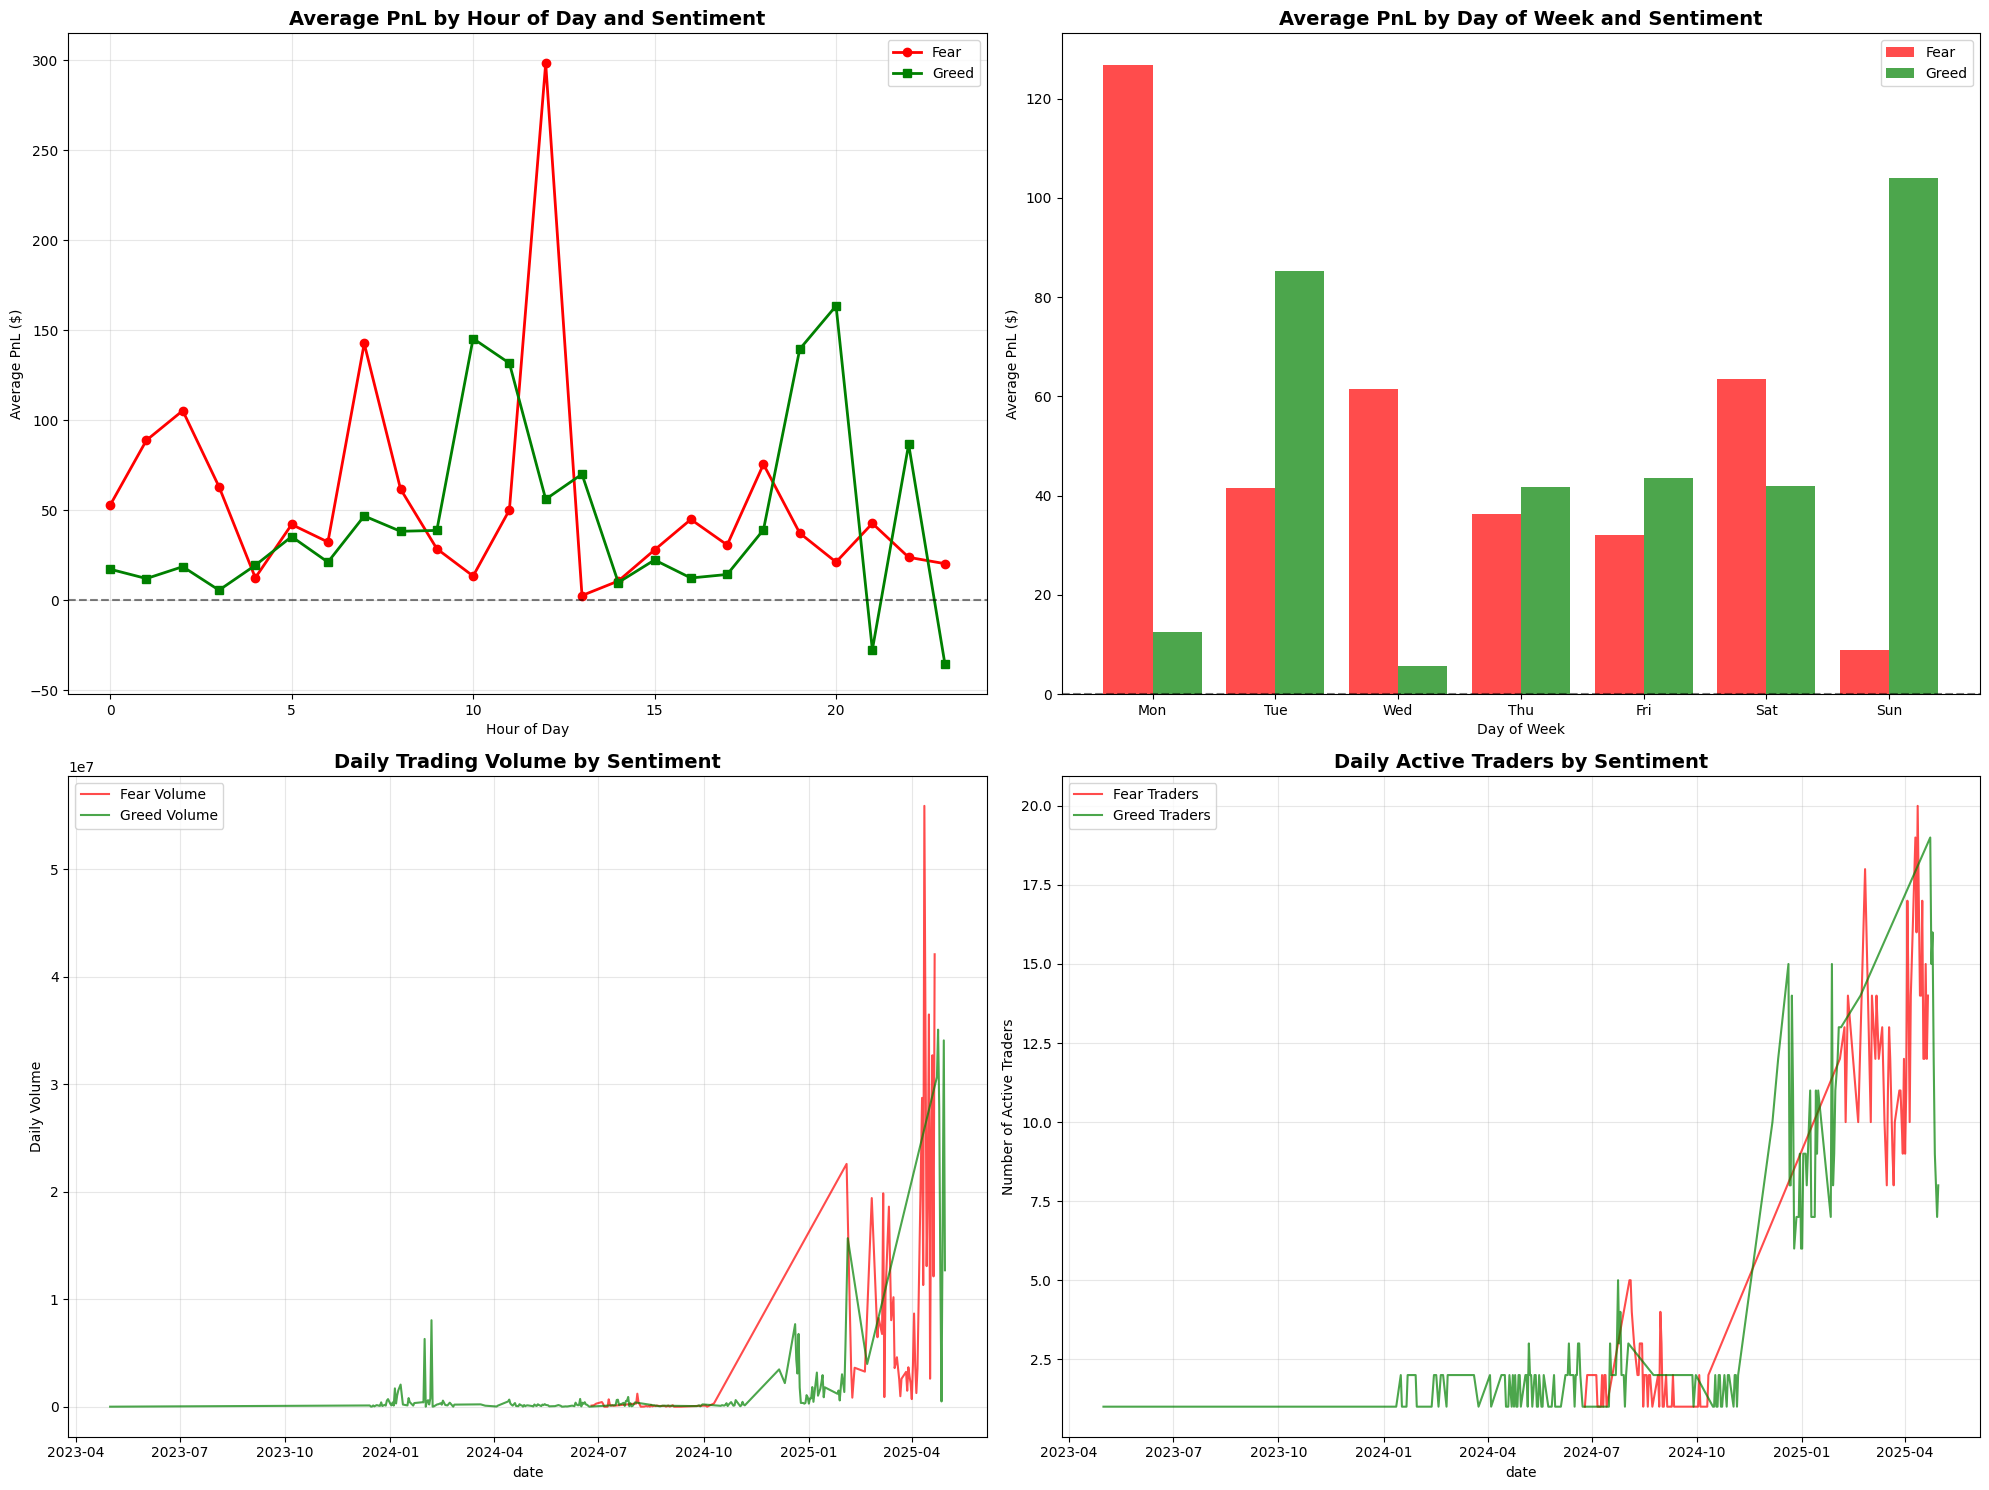

In [16]:
print("\n⏰ TEMPORAL PATTERN ANALYSIS")
print("-" * 40)

# Analyze patterns by time of day, day of week, etc.
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# 1. Hourly trading patterns by sentiment
hourly_sentiment = merged_df.groupby(['hour', 'classification'])['Closed PnL'].mean().reset_index()
hourly_pivot = hourly_sentiment.pivot(index='hour', columns='classification', values='Closed PnL')

if 'Fear' in hourly_pivot.columns and 'Greed' in hourly_pivot.columns:
    ax1.plot(hourly_pivot.index, hourly_pivot['Fear'], color='red', marker='o', label='Fear', linewidth=2)
    ax1.plot(hourly_pivot.index, hourly_pivot['Greed'], color='green', marker='s', label='Greed', linewidth=2)
    ax1.set_title('Average PnL by Hour of Day and Sentiment', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Hour of Day')
    ax1.set_ylabel('Average PnL ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axhline(0, color='black', linestyle='--', alpha=0.5)

# 2. Day of week patterns
dow_sentiment = merged_df.groupby(['day_of_week', 'classification'])['Closed PnL'].mean().reset_index()
dow_pivot = dow_sentiment.pivot(index='day_of_week', columns='classification', values='Closed PnL')

if 'Fear' in dow_pivot.columns and 'Greed' in dow_pivot.columns:
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    ax2.bar([x-0.2 for x in range(7)], dow_pivot['Fear'], width=0.4, color='red', alpha=0.7, label='Fear')
    ax2.bar([x+0.2 for x in range(7)], dow_pivot['Greed'], width=0.4, color='green', alpha=0.7, label='Greed')
    ax2.set_title('Average PnL by Day of Week and Sentiment', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Day of Week')
    ax2.set_ylabel('Average PnL ($)')
    ax2.set_xticks(range(7))
    ax2.set_xticklabels(days)
    ax2.legend()
    ax2.axhline(0, color='black', linestyle='--', alpha=0.5)

# 3. Volume patterns by sentiment over time
daily_volume_sentiment = merged_df.groupby(['date', 'classification']).agg({
    'size': 'sum',
    'Account': 'nunique'
}).reset_index()

# Plot volume trends
for sentiment in ['Fear', 'Greed']:
    data = daily_volume_sentiment[daily_volume_sentiment['classification'] == sentiment]
    color = 'red' if sentiment == 'Fear' else 'green'
    ax3.plot(data['date'], data['size'], color=color, alpha=0.7, label=f'{sentiment} Volume', linewidth=1.5)

ax3.set_title('Daily Trading Volume by Sentiment', fontsize=14, fontweight='bold')
ax3.set_xlabel('date')
ax3.set_ylabel('Daily Volume')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Active traders by sentiment
for sentiment in ['Fear', 'Greed']:
    data = daily_volume_sentiment[daily_volume_sentiment['classification'] == sentiment]
    color = 'red' if sentiment == 'Fear' else 'green'
    ax4.plot(data['date'], data['Account'], color=color, alpha=0.7, label=f'{sentiment} Traders', linewidth=1.5)

ax4.set_title('Daily Active Traders by Sentiment', fontsize=14, fontweight='bold')
ax4.set_xlabel('date')
ax4.set_ylabel('Number of Active Traders')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/output/temporal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()


🔄 CONTRARIAN VS MOMENTUM ANALYSIS
----------------------------------------
Performance during sentiment transitions:
                    mean   count       std
transition_type                           
fear_to_greed     8.9900       2   12.7138
greed_to_fear     0.0000       2    0.0000
stable           48.5501  211214  917.9985


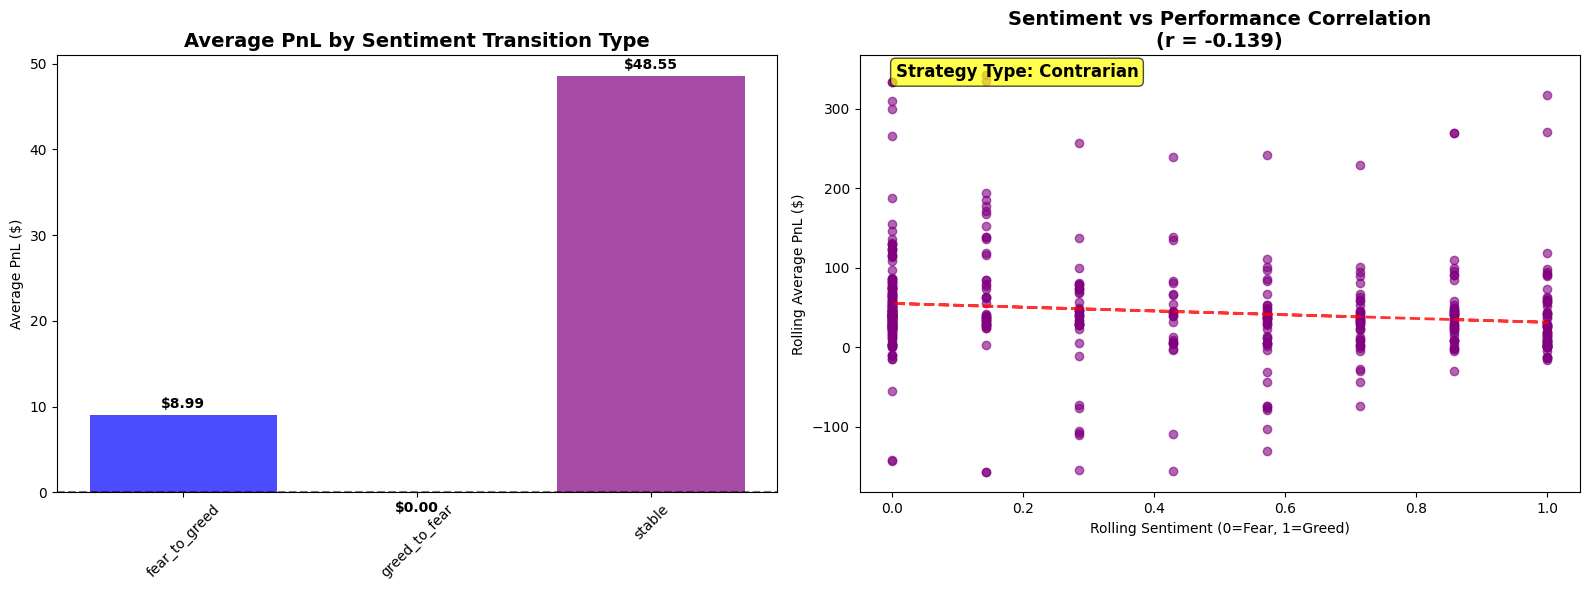

In [17]:
print("\n🔄 CONTRARIAN VS MOMENTUM ANALYSIS")
print("-" * 40)

# Analyze if traders are contrarian (perform better during fear) or momentum followers
def sentiment_transition_analysis(df):
    """Analyze performance around sentiment transitions"""
    df_sorted = df.sort_values(['date', 'Timestamp']).reset_index(drop=True)

    # Identify sentiment changes
    df_sorted['prev_sentiment'] = df_sorted['classification'].shift(1)
    df_sorted['sentiment_change'] = df_sorted['classification'] != df_sorted['prev_sentiment']

    # Mark transition periods
    df_sorted['transition_type'] = 'stable'
    fear_to_greed = (df_sorted['prev_sentiment'] == 'Fear') & (df_sorted['classification'] == 'Greed')
    greed_to_fear = (df_sorted['prev_sentiment'] == 'Greed') & (df_sorted['classification'] == 'Fear')

    df_sorted.loc[fear_to_greed, 'transition_type'] = 'fear_to_greed'
    df_sorted.loc[greed_to_fear, 'transition_type'] = 'greed_to_fear'

    return df_sorted

# Perform transition analysis
transition_df = sentiment_transition_analysis(merged_df)

# Analyze performance during transitions
transition_performance = transition_df.groupby('transition_type')['Closed PnL'].agg(['mean', 'count', 'std']).round(4)
print("Performance during sentiment transitions:")
print(transition_performance)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Performance by transition type
transition_types = transition_performance.index
performance_means = transition_performance['mean']
colors = ['blue', 'orange', 'purple']

bars = ax1.bar(transition_types, performance_means, color=colors, alpha=0.7)
ax1.set_title('Average PnL by Sentiment Transition Type', fontsize=14, fontweight='bold')
ax1.set_ylabel('Average PnL ($)')
ax1.axhline(0, color='black', linestyle='--', alpha=0.5)
ax1.tick_params(axis='x', rotation=45)

# Add value labels
for bar, value in zip(bars, performance_means):
    ax1.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + (0.5 if value > 0 else -1),
             f'${value:.2f}', ha='center', va='bottom' if value > 0 else 'top',
             fontweight='bold')

# Contrarian indicator analysis
# Calculate rolling sentiment and performance correlation
window = 7  # 7-day window
daily_metrics = merged_df.groupby('date').agg({
    'Closed PnL': 'mean',
    'classification': lambda x: 1 if x.iloc[0] == 'Greed' else 0  # Binary encoding
}).reset_index()

if len(daily_metrics) > window:
    daily_metrics['rolling_sentiment'] = daily_metrics['classification'].rolling(window).mean()
    daily_metrics['rolling_pnl'] = daily_metrics['Closed PnL'].rolling(window).mean()

    # Remove NaN values
    clean_data = daily_metrics.dropna()

    if len(clean_data) > 0:
        correlation = clean_data['rolling_sentiment'].corr(clean_data['rolling_pnl'])

        ax2.scatter(clean_data['rolling_sentiment'], clean_data['rolling_pnl'], alpha=0.6, color='purple')
        ax2.set_title(f'Sentiment vs Performance Correlation\n(r = {correlation:.3f})', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Rolling Sentiment (0=Fear, 1=Greed)')
        ax2.set_ylabel('Rolling Average PnL ($)')

        # Add trend line
        z = np.polyfit(clean_data['rolling_sentiment'], clean_data['rolling_pnl'], 1)
        p = np.poly1d(z)
        ax2.plot(clean_data['rolling_sentiment'], p(clean_data['rolling_sentiment']),
                 "r--", alpha=0.8, linewidth=2)

        # Interpretation
        if correlation > 0.1:
            strategy_type = "Momentum Following"
        elif correlation < -0.1:
            strategy_type = "Contrarian"
        else:
            strategy_type = "Neutral/Mixed"

        ax2.text(0.05, 0.95, f'Strategy Type: {strategy_type}',
                transform=ax2.transAxes, fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/output/contrarian_momentum_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


👥 TRADER CLUSTERING ANALYSIS
----------------------------------------
Analyzing 32 traders with ≥5 trades
Optimal number of clusters: 2

Trader Cluster Analysis:
         Closed PnL_mean  Closed PnL_sum  Size USD_mean  greed_preference
cluster                                                                  
0                91.5758     267227.5073      3644.3421            0.2400
1               133.3002     693029.1864     22539.7210            0.1793


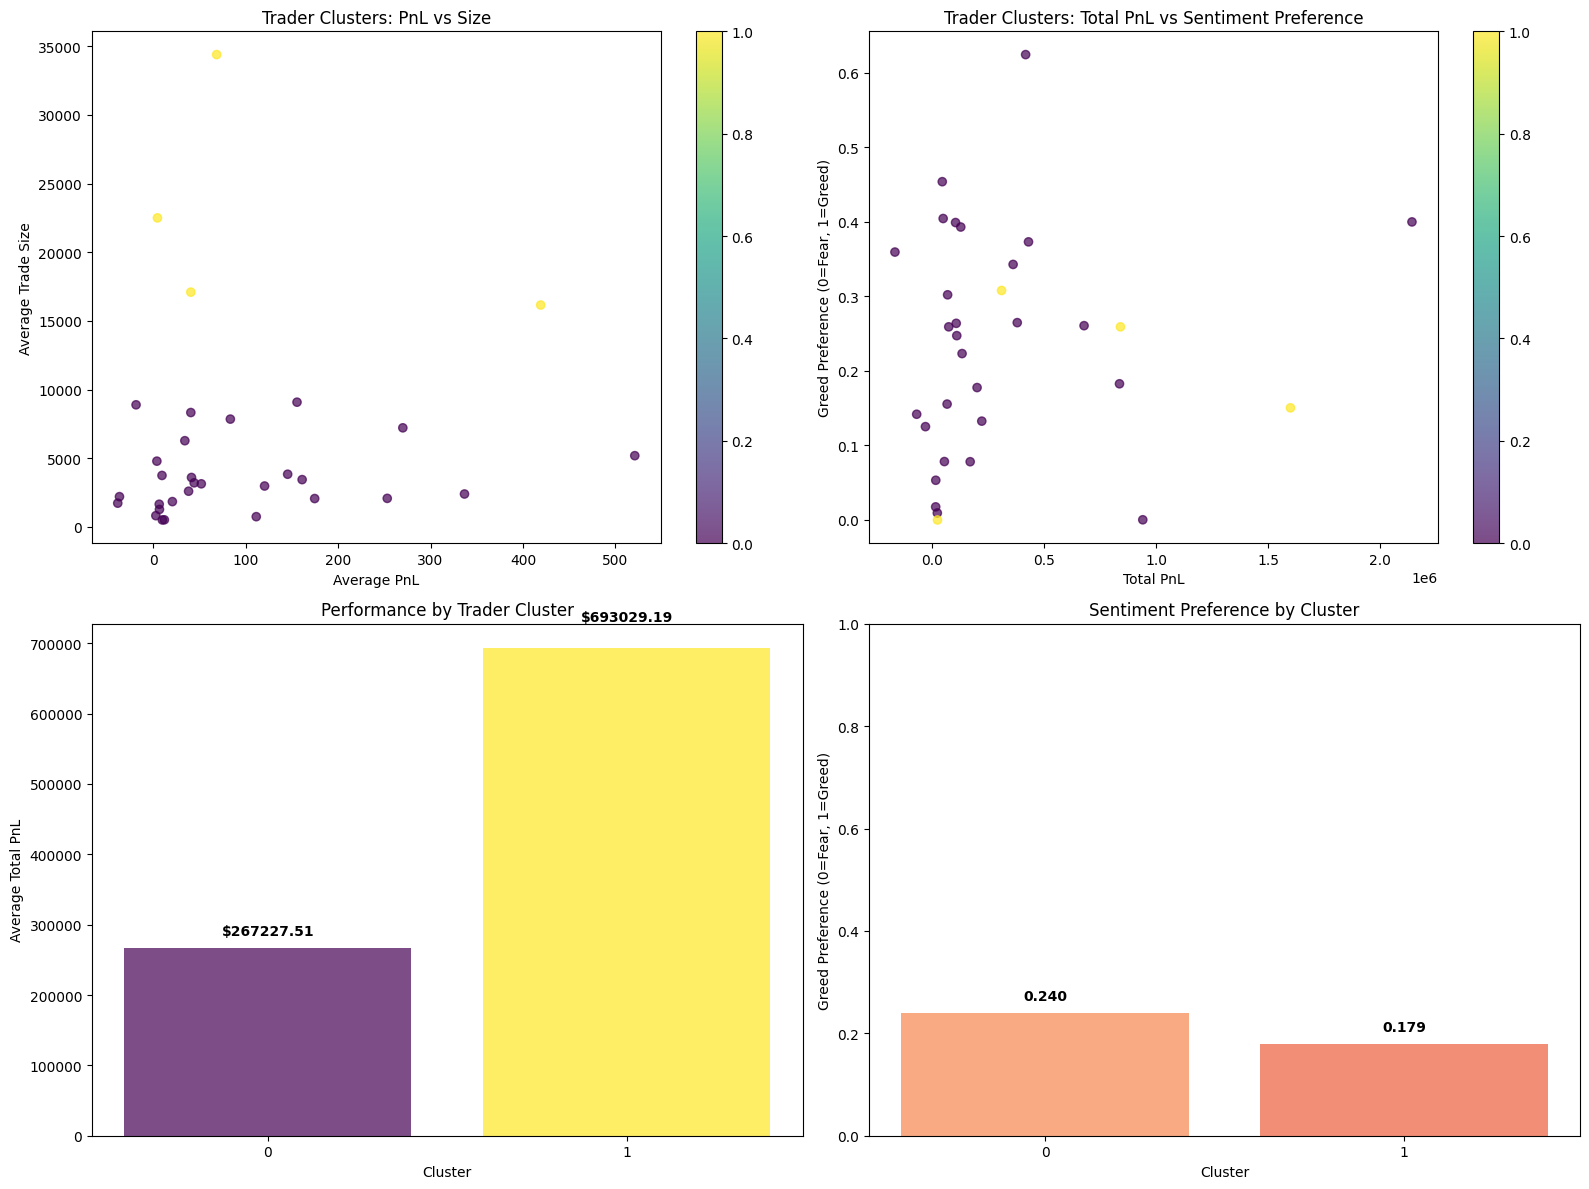

In [22]:
print("\n👥 TRADER CLUSTERING ANALYSIS")
print("-" * 40)

# Perform clustering analysis on trader behavior
trader_features = merged_df.groupby('Account').agg({
    'Closed PnL': ['mean', 'std', 'sum'],
    'size': ['mean', 'sum'],
    'position_value': 'mean'
}).round(4)

# Flatten column names
trader_features.columns = ['_'.join(col).strip() for col in trader_features.columns.values]
trader_features = trader_features.reset_index()

# Add sentiment preference
trader_sentiment = merged_df.groupby('Account')['classification'].apply(
    lambda x: (x == 'Greed').mean()
).reset_index()
trader_sentiment.columns = ['Account', 'greed_preference']

trader_features = trader_features.merge(trader_sentiment, on='Account')

# Remove traders with insufficient data
min_trades = 5
trader_trade_counts = merged_df['Account'].value_counts()
active_traders = trader_trade_counts[trader_trade_counts >= min_trades].index
trader_features = trader_features[trader_features['Account'].isin(active_traders)]

print(f"Analyzing {len(trader_features)} traders with ≥{min_trades} trades")

# Prepare features for clustering
feature_cols = [col for col in trader_features.columns if col != 'Account']
X = trader_features[feature_cols].fillna(0)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters
silhouette_scores = []
K_range = range(2, min(8, len(trader_features)//2 + 1)) # Adjust K_range based on data size

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # Add n_init to suppress warning
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_score_val = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_score_val)

if silhouette_scores:
    optimal_k = K_range[np.argmax(silhouette_scores)]
    print(f"Optimal number of clusters: {optimal_k}")

    # Perform final clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10) # Add n_init
    trader_features['cluster'] = kmeans.fit_predict(X_scaled)

    # Analyze clusters
    cluster_analysis = trader_features.groupby('cluster').agg({
        'Closed PnL_mean': 'mean',
        'Closed PnL_sum': 'mean',
        'size_mean': 'mean',
        'greed_preference': 'mean'
    }).round(4)

    print("\nTrader Cluster Analysis:")
    print(cluster_analysis)

    # Visualize clusters
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

    # Cluster by PnL and Size
    scatter = ax1.scatter(trader_features['Closed PnL_mean'], trader_features['size_mean'],
                         c=trader_features['cluster'], cmap='viridis', alpha=0.7)
    ax1.set_xlabel('Average PnL')
    ax1.set_ylabel('Average Trade Size')
    ax1.set_title('Trader Clusters: PnL vs Size')
    plt.colorbar(scatter, ax=ax1)

    # Cluster by PnL Sum and Sentiment Preference
    scatter = ax2.scatter(trader_features['Closed PnL_sum'], trader_features['greed_preference'],
                         c=trader_features['cluster'], cmap='viridis', alpha=0.7)
    ax2.set_xlabel('Total PnL')
    ax2.set_ylabel('Greed Preference (0=Fear, 1=Greed)')
    ax2.set_title('Trader Clusters: Total PnL vs Sentiment Preference')
    plt.colorbar(scatter, ax=ax2)

    # Cluster performance comparison
    cluster_performance = trader_features.groupby('cluster')['Closed PnL_sum'].mean()
    bars = ax3.bar(range(len(cluster_performance)), cluster_performance,
                   color=plt.cm.viridis(np.linspace(0, 1, len(cluster_performance))), alpha=0.7)
    ax3.set_xlabel('Cluster')
    ax3.set_ylabel('Average Total PnL')
    ax3.set_title('Performance by Trader Cluster')
    ax3.set_xticks(range(len(cluster_performance)))

    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, cluster_performance)):
        ax3.text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + abs(bar.get_height())*0.05,
                 f'${value:.2f}', ha='center', va='bottom', fontweight='bold')

    # Sentiment preference by cluster
    sentiment_pref = trader_features.groupby('cluster')['greed_preference'].mean()
    bars = ax4.bar(range(len(sentiment_pref)), sentiment_pref,
                   color=plt.cm.RdYlGn(sentiment_pref), alpha=0.7)
    ax4.set_xlabel('Cluster')
    ax4.set_ylabel('Greed Preference (0=Fear, 1=Greed)')
    ax4.set_title('Sentiment Preference by Cluster')
    ax4.set_xticks(range(len(sentiment_pref)))
    ax4.set_ylim(0, 1)

    # Add value labels
    for i, (bar, value) in enumerate(zip(bars, sentiment_pref)):
        ax4.text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 0.02,
                 f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig('/content/outputs/trader_clustering_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Not enough data to perform clustering analysis.")

In [23]:
print("\n💡 STRATEGIC INSIGHTS AND RECOMMENDATIONS")
print("-" * 50)

# Generate comprehensive insights
insights = []

# 1. Performance by sentiment
fear_performance = merged_df[merged_df['classification'] == 'Fear']['Closed PnL'].mean()
greed_performance = merged_df[merged_df['classification'] == 'Greed']['Closed PnL'].mean()

if fear_performance > greed_performance:
    insights.append(f"🔍 CONTRARIAN SIGNAL: Traders perform {((fear_performance/greed_performance - 1)*100):+.1f}% better during FEAR periods")
    strategy_recommendation = "Consider increasing position sizes during market fear periods"
else:
    insights.append(f"📈 MOMENTUM SIGNAL: Traders perform {((greed_performance/fear_performance - 1)*100):+.1f}% better during GREED periods")
    strategy_recommendation = "Consider increasing position sizes during market greed periods"

# 2. Volume analysis
fear_volume = merged_df[merged_df['classification'] == 'Fear']['Size USD'].sum()
greed_volume = merged_df[merged_df['classification'] == 'Greed']['Size USD'].sum()
fear_days = merged_df[merged_df['classification'] == 'Fear']['date'].nunique()
greed_days = merged_df[merged_df['classification'] == 'Greed']['date'].nunique()

if fear_days > 0 and greed_days > 0:
    fear_avg_daily = fear_volume / fear_days
    greed_avg_daily = greed_volume / greed_days

    if fear_avg_daily > greed_avg_daily:
        insights.append(f"📊 VOLUME INSIGHT: {((fear_avg_daily/greed_avg_daily - 1)*100):+.1f}% higher daily volume during FEAR periods")
    else:
        insights.append(f"📊 VOLUME INSIGHT: {((greed_avg_daily/fear_avg_daily - 1)*100):+.1f}% higher daily volume during GREED periods")

# 3. Win rate analysis
fear_winrate = (merged_df[merged_df['classification'] == 'Fear']['Closed PnL'] > 0).mean() * 100
greed_winrate = (merged_df[merged_df['classification'] == 'Greed']['Closed PnL'] > 0).mean() * 100

insights.append(f"🎯 WIN RATES: Fear periods: {fear_winrate:.1f}%, Greed periods: {greed_winrate:.1f}%")

# Print insights
print("KEY FINDINGS:")
for i, insight in enumerate(insights, 1):
    print(f"{i}. {insight}")

print(f"\n🎯 PRIMARY STRATEGY RECOMMENDATION:")
print(f"   {strategy_recommendation}")
# Removed leverage risk recommendation


💡 STRATEGIC INSIGHTS AND RECOMMENDATIONS
--------------------------------------------------
KEY FINDINGS:
1. 🔍 CONTRARIAN SIGNAL: Traders perform +27.0% better during FEAR periods
2. 📊 VOLUME INSIGHT: +255.2% higher daily volume during FEAR periods
3. 🎯 WIN RATES: Fear periods: 42.1%, Greed periods: 38.5%

🎯 PRIMARY STRATEGY RECOMMENDATION:
   Consider increasing position sizes during market fear periods



📋 GENERATING FINAL SUMMARY
----------------------------------------


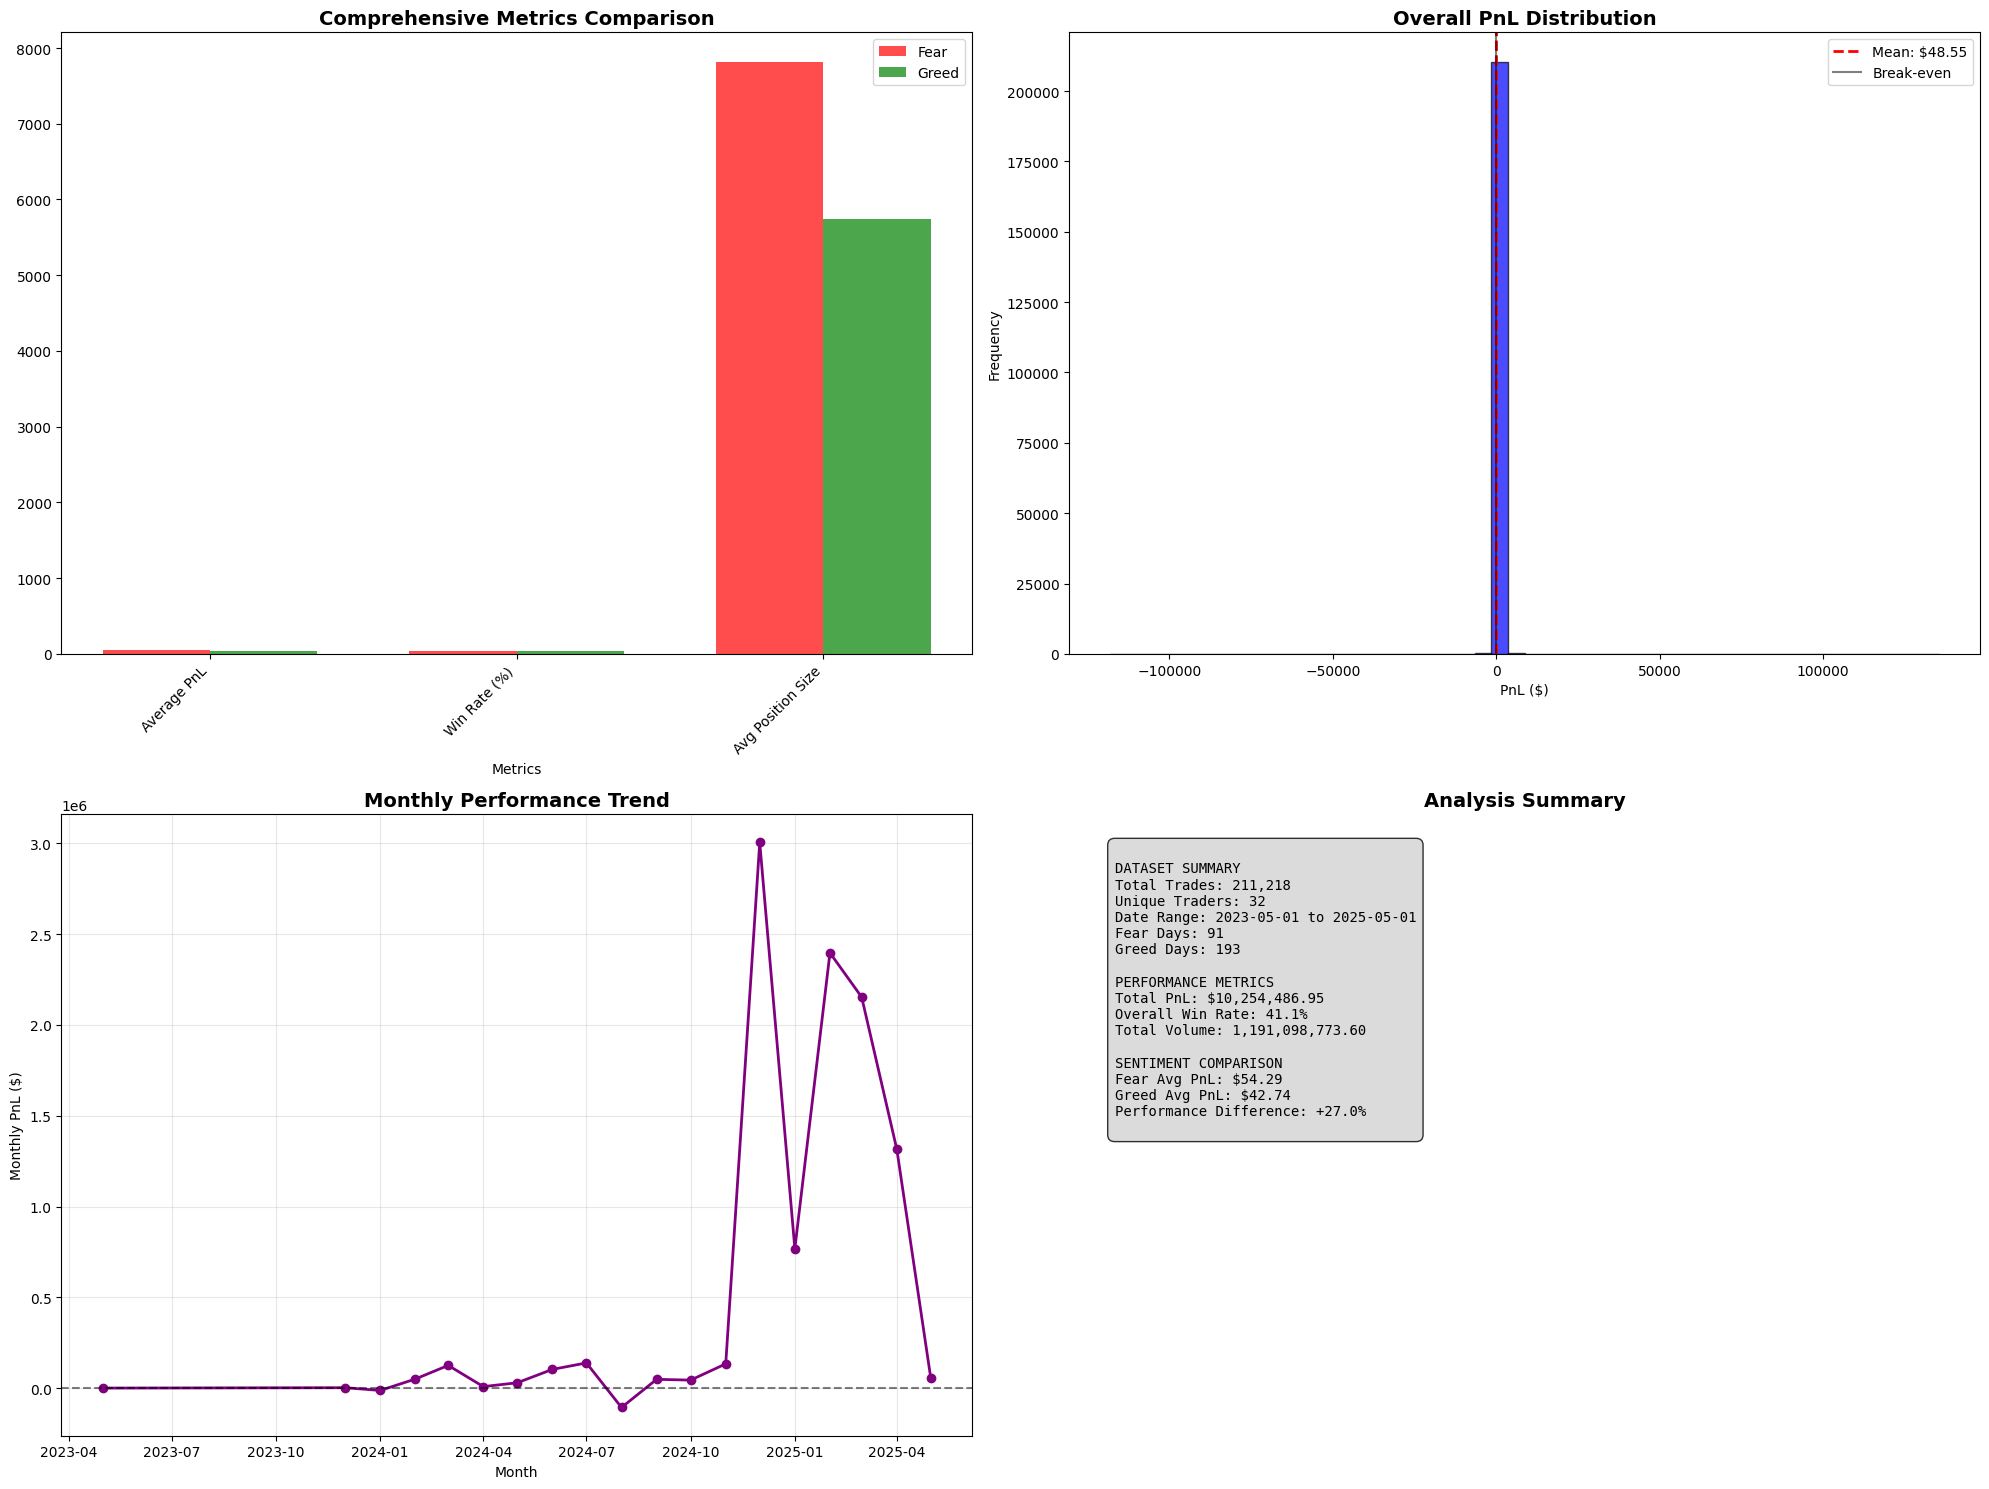

✅ Final analysis results saved to: /content/drive/MyDrive/output/final_analysis_results.csv


In [24]:
print("\n📋 GENERATING FINAL SUMMARY")
print("-" * 40)

# Create comprehensive summary statistics
summary_stats = {
    'total_trades': len(merged_df),
    'unique_traders': merged_df['Account'].nunique(),
    'date_range': f"{merged_df['date'].min().strftime('%Y-%m-%d')} to {merged_df['date'].max().strftime('%Y-%m-%d')}",
    'fear_days': fear_days,
    'greed_days': greed_days,
    'overall_pnl': merged_df['Closed PnL'].sum(),
    'overall_winrate': (merged_df['Closed PnL'] > 0).mean() * 100,
    'total_volume': merged_df['Size USD'].sum()
}

# Create final insights visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 15))

# Summary metrics comparison
metrics = ['Average PnL', 'Win Rate (%)', 'Avg Position Size']
fear_values = [
    fear_performance,
    fear_winrate,
    merged_df[merged_df['classification'] == 'Fear']['Size USD'].mean()
]
greed_values = [
    greed_performance,
    greed_winrate,
    merged_df[merged_df['classification'] == 'Greed']['Size USD'].mean()
]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax1.bar(x - width/2, fear_values, width, label='Fear', color='red', alpha=0.7)
bars2 = ax1.bar(x + width/2, greed_values, width, label='Greed', color='green', alpha=0.7)

ax1.set_xlabel('Metrics')
ax1.set_title('Comprehensive Metrics Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45, ha='right')
ax1.legend()

# Performance distribution
all_pnl = merged_df['Closed PnL']
ax2.hist(all_pnl, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax2.axvline(all_pnl.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${all_pnl.mean():.2f}')
ax2.axvline(0, color='black', linestyle='-', alpha=0.5, label='Break-even')
ax2.set_title('Overall PnL Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('PnL ($)')
ax2.set_ylabel('Frequency')
ax2.legend()

# Monthly performance trend
monthly_performance = merged_df.groupby(merged_df['date'].dt.to_period('M')).agg({
    'Closed PnL': 'sum'
}).reset_index()
monthly_performance['date'] = monthly_performance['date'].dt.to_timestamp()

ax3.plot(monthly_performance['date'], monthly_performance['Closed PnL'],
         marker='o', linewidth=2, markersize=6, color='purple')
ax3.set_title('Monthly Performance Trend', fontsize=14, fontweight='bold')
ax3.set_xlabel('Month')
ax3.set_ylabel('Monthly PnL ($)')
ax3.grid(True, alpha=0.3)
ax3.axhline(0, color='black', linestyle='--', alpha=0.5)

# Key statistics summary
stats_text = f"""
DATASET SUMMARY
Total Trades: {summary_stats['total_trades']:,}
Unique Traders: {summary_stats['unique_traders']:,}
Date Range: {summary_stats['date_range']}
Fear Days: {summary_stats['fear_days']}
Greed Days: {summary_stats['greed_days']}

PERFORMANCE METRICS
Total PnL: ${summary_stats['overall_pnl']:,.2f}
Overall Win Rate: {summary_stats['overall_winrate']:.1f}%
Total Volume: {summary_stats['total_volume']:,.2f}

SENTIMENT COMPARISON
Fear Avg PnL: ${fear_performance:.2f}
Greed Avg PnL: ${greed_performance:.2f}
Performance Difference: {((max(fear_performance, greed_performance)/min(fear_performance, greed_performance) - 1)*100):+.1f}%
"""

ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)
ax4.axis('off')
ax4.set_title('Analysis Summary', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/output/trading_strategy_insights.png', dpi=300, bbox_inches='tight')
plt.show()

# Save final analysis results
results_df = pd.DataFrame({
    'Metric': ['Fear_Avg_PnL', 'Greed_Avg_PnL', 'Fear_Win_Rate', 'Greed_Win_Rate',
               'Total_Trades', 'Unique_Traders'],
    'Value': [fear_performance, greed_performance, fear_winrate, greed_winrate,
              len(merged_df), merged_df['Account'].nunique()]
})

results_df.to_csv('/content/drive/MyDrive/output/final_analysis_results.csv', index=False)
print("✅ Final analysis results saved to: /content/drive/MyDrive/output/final_analysis_results.csv")